<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/TwoDomainsHomotopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

plt.style.use('ggplot')

In [23]:
class Model0(nn.Module):
    def __init__(self, width):
        super(Model0, self).__init__()
        self.layer1 = nn.Linear(2, width)
        self.layer2 = nn.Linear(width, 2)
        self.layer3 = nn.Linear(2, 1)
        
    def forward(self, xd):
        x = xd[:,:2]
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        p = torch.sigmoid(self.layer3(x))[:,0]
        return p


class Model1(nn.Module):
    def __init__(self, width):
        super(Model1, self).__init__()
        self.layer1 = nn.Linear(3, width)
        self.layer2 = nn.Linear(width, 2)
        self.layer3 = nn.Linear(2, 1)
        
    def forward(self, xd):
        x = torch.tanh(self.layer1(xd))
        x = torch.tanh(self.layer2(x))
        p = torch.sigmoid(self.layer3(x))[:,0]
        return p


class Model2(nn.Module):
    def __init__(self, width):
        super(Model2, self).__init__()
        self.layer11 = nn.Linear(2, width)
        self.layer21 = nn.Linear(width, 2)
        self.layer12 = nn.Linear(2, width)
        self.layer22 = nn.Linear(width, 2)
        self.layer3 = nn.Linear(2, 1)
        
    def forward(self, xd):
        d = xd[:, 2]
        x = xd[:, :2]
        idxs1 = d==1
        idxs2 = d==2
        x1 = x[idxs1]
        x2 = x[idxs2]
        x1 = torch.tanh(self.layer11(x1))
        x1 = torch.tanh(self.layer21(x1))
        x2 = torch.tanh(self.layer12(x2))
        x2 = torch.tanh(self.layer22(x2))
        x1 = self.layer3(x1)
        x2 = self.layer3(x2)
        logits = torch.zeros(d.shape[0], 1)
        logits[idxs1] = x1
        logits[idxs2] = x2
        return torch.sigmoid(logits)[:,0]

In [24]:
model0 = Model0(5)
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.001)

model01 = Model0(5)
optimizer01 = torch.optim.Adam(model01.parameters(), lr=0.001)

model02 = Model0(5)
optimizer02 = torch.optim.Adam(model02.parameters(), lr=0.001)

model1 = Model1(5)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

model2 = Model2(3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

loss_fn = nn.BCELoss()

In [25]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = [model0, model01, model02, model1, model2]
for m in models:
    print(get_parameter_count(m))

30
30
30
35
37


In [26]:
def get_circle(x0, y0, n, r=1, seed=42):
    np.random.seed(seed)
    xy = pd.DataFrame(np.random.rand(n*2, 2) * 2 - 1)
    r_ = xy.apply(lambda xy: np.sqrt(xy[0]**2+xy[1]**2), axis=1)
    xy = xy.loc[r_<=1].iloc[:n].values * r
    return xy + np.array([x0,y0])

tensor(0.5000) tensor(0.5000)


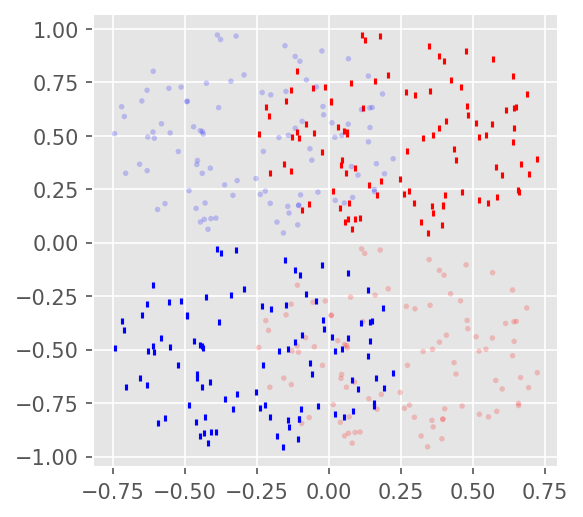

In [27]:
N1 = 2000
N2 = 2000
EPOCHS = 5000
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

X1p = get_circle(1/4,1/2, N1, 1/2)
X1n = get_circle(1/4,-1/2, N1, 1/2)
X1 = np.vstack((X1p, X1n))
X2p = get_circle(-1/4,-1/2, N2, 1/2)
X2n = get_circle(-1/4,1/2, N2, 1/2)
X2 = np.vstack((X2p, X2n))
X = np.vstack((X1, X2))
d = np.reshape([1]*(2*N1)+[2]*(2*N2), (2*(N1+N2),1))
Xd = np.hstack((X, d))
y1p = np.ones(N1)
y1n = np.zeros(N2)
y1 = np.concatenate((y1p, y1n))
y2p = np.ones(N2)
y2n = np.zeros(N2)
y2 = np.concatenate((y2p, y2n))
y = np.concatenate((y1, y2))

Xd = Variable(torch.from_numpy(Xd)).float()
y = Variable(torch.from_numpy(y)).float()
Xd1, Xd2 = Xd[:2*N1], Xd[2*N1:]
y1, y2 = y[:2*N2], y[2*N1:]

print((y1==1).sum()/y1.shape[0], (y2==1).sum()/y2.shape[0])

fig, ax = plt.subplots(figsize=(4,4), dpi=150)
n = 100
ax.scatter(*X1[y1==0][:n].T, s=7, marker='o', c='r', alpha=0.2, ec='none')
ax.scatter(*X1[y1==1][:n].T, s=10, marker='|', c='r')
ax.scatter(*X2[y2==0][:n].T, s=7, marker='o', c='b', alpha=0.2, ec='none')
ax.scatter(*X2[y2==1][:n].T, s=10, marker='|', c='b')
plt.show()

Bayes error rate = $\displaystyle \frac{A_{chip}}{A_{circle}} = \frac{1}{4} - \frac{1}{2\pi} \approx 0.09$

$\displaystyle r = \sqrt{2}$

$\displaystyle A_{circle} = 2\pi$

$\displaystyle A_{chip} = \frac{1}{4} A_{circle} - \frac{(\sqrt{2})^2}{2} = \frac{\pi}{2} - 1$

In [28]:
def train_and_validate(model, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    """
    """
    losss = []
    accus = []
    ps = []

    for epoch in tqdm.trange(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            idxs1 = X_test[:,2]==1
            idxs2 = X_test[:,2]==2
            bools1 = ((y_pred[idxs1]>0.5).long() == y_test[idxs1]).type(torch.FloatTensor)
            bools2 = ((y_pred[idxs2]>0.5).long() == y_test[idxs2]).type(torch.FloatTensor)
            accus.append([bools1.mean(), bools2.mean()])

    return np.array(losss), np.array(accus)

In [29]:
from sklearn.model_selection import train_test_split

Xd1_train, Xd1_test, y1_train, y1_test =\
    train_test_split(Xd1, y1, train_size=0.5, random_state=SEED)
Xd2_train, Xd2_test, y2_train, y2_test =\
    train_test_split(Xd2, y2, train_size=0.5, random_state=SEED)
Xd_train = torch.cat((Xd1_train, Xd2_train), 0)
y_train = torch.cat((y1_train, y2_train), 0)
Xd_test = torch.cat((Xd1_test, Xd2_test), 0)
y_test = torch.cat((y1_test, y2_test), 0)

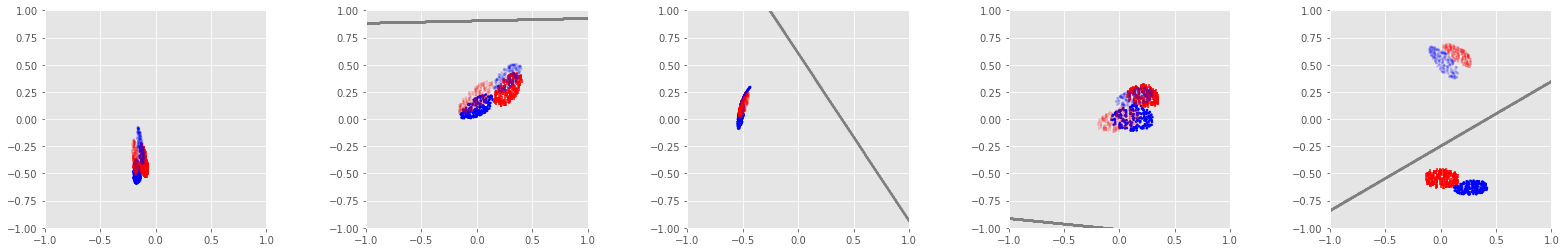

In [30]:
def plot_homotopy(models):

    fig, axs = plt.subplots(figsize=(27,4), ncols=5)

    info = [[['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
            [['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
            [['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
            [['layer1', 'layer2', 3], ['layer1', 'layer2', 3]], 
            [['layer11', 'layer21', 2], ['layer12', 'layer22', 2]]]

    for i, ax in enumerate(axs):
        m = models[i]

        (f11, f21, k1), (f12, f22, k2) = info[i]

        #print(getattr(m, f11).weight.data.detach().numpy().flatten())

        X1_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(Xd1[:,:k1]))))
        X2_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(Xd2[:,:k2]))))

        n = 200

        w1, w2 = m.layer3.weight.data.detach().numpy().flatten()
        b = m.layer3.bias.data.detach().numpy()[0]
        x1_ = np.linspace(-1, 1, 1001)
        x2_ = -(x1_*w1+b) / w2
        ax.scatter(x1_, x2_, color='grey', s=2)

        ax.scatter(*X1_[y1==0][:n].T.detach().numpy(), s=7, marker='o', c='b', alpha=1, ec='none')
        ax.scatter(*X1_[y1==1][:n].T.detach().numpy(), s=10, marker='|', c='r', alpha=1)
        ax.scatter(*X2_[y2==0][:n].T.detach().numpy(), s=7, marker='o', c='b', alpha=0.2, ec='none')
        ax.scatter(*X2_[y2==1][:n].T.detach().numpy(), s=10, marker='|', c='r', alpha=0.2)

        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)

    plt.subplots_adjust(wspace=0.45)
    plt.show()

plot_homotopy(models)

In [31]:
losss0, accus0 = train_and_validate(model0, optimizer0, loss_fn, Xd_train, y_train, Xd_test, y_test)
# losss01, accus01 = train_and_validate(model01, optimizer01, loss_fn, Xd1_train, y1_train, Xd_test, y_test)
# losss02, accus02 = train_and_validate(model02, optimizer02, loss_fn, Xd2_train, y2_train, Xd_test, y_test)
losss1, accus1 = train_and_validate(model1, optimizer1, loss_fn, Xd_train, y_train, Xd_test, y_test)
losss2, accus2 = train_and_validate(model2, optimizer2, loss_fn, Xd_train, y_train, Xd_test, y_test)

100%|██████████| 5000/5000 [00:17<00:00, 288.18it/s]


In [32]:
# losss = [losss0, losss01, losss02, losss1, losss2]
# accus = [accus0, accus01, accus02, accus1, accus2]

losss = [losss0, losss1, losss2]
accus = [accus0, accus1, accus2]

In [33]:
accus[0].shape

(5000, 2)

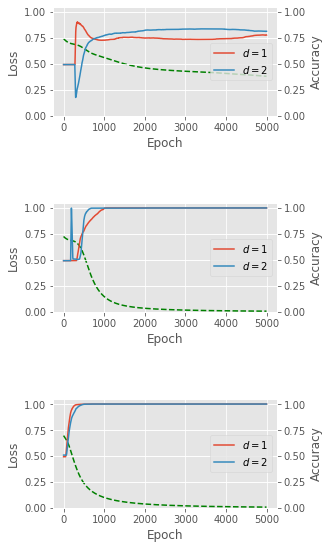

In [34]:
fig, axs = plt.subplots(figsize=(4,12), nrows=3)

for i, ax in enumerate(axs):
    ax.plot(losss[i], color='g', linestyle='--')
    ax.set_ylabel('Loss')
    ax2 = ax.twinx()
    ax2.plot(accus[i][:,0], label=r'$d=1$')
    ax2.plot(accus[i][:,1], label=r'$d=2$')
    ax2.legend(loc='center right')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1.05)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Epoch')

plt.subplots_adjust(wspace=0.8, bottom=0.3, hspace=0.8)
plt.show()

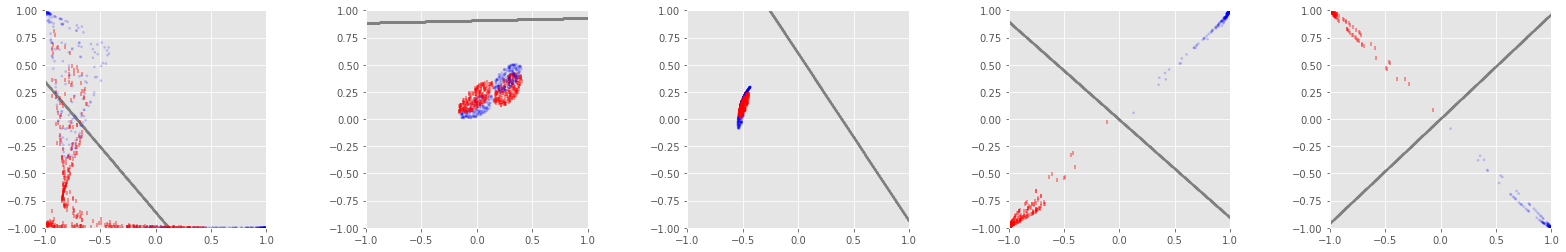

In [35]:
fig, axs = plt.subplots(figsize=(27,4), ncols=5)

info = [[['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
        [['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
        [['layer1', 'layer2', 2], ['layer1', 'layer2', 2]],
        [['layer1', 'layer2', 3], ['layer1', 'layer2', 3]], 
        [['layer11', 'layer21', 2], ['layer12', 'layer22', 2]]]

for i, ax in enumerate(axs):
    m = models[i]
    (f11, f21, k1), (f12, f22, k2) = info[i]

    X1_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(Xd1[:,:k1]))))
    X2_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(Xd2[:,:k2]))))

    n = 200

    w1, w2 = m.layer3.weight.data.detach().numpy().flatten()
    b = m.layer3.bias.data.detach().numpy()[0]
    x1_ = np.linspace(-1, 1, 1001)
    x2_ = -(x1_*w1+b) / w2
    ax.scatter(x1_, x2_, color='grey', s=2)

    ax.scatter(*X1_[y1==0][:n].T.detach().numpy(), s=7, marker='o', c='b', alpha=0.2, ec='none')
    ax.scatter(*X1_[y1==1][:n].T.detach().numpy(), s=10, marker='|', c='r', alpha=0.5)
    ax.scatter(*X2_[y2==0][:n].T.detach().numpy(), s=7, marker='o', c='b', alpha=0.2, ec='none')
    ax.scatter(*X2_[y2==1][:n].T.detach().numpy(), s=10, marker='|', c='r', alpha=0.5)

    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)

plt.subplots_adjust(wspace=0.45)
plt.show()

In [36]:
accus0[-1], accus1[-1], accus2[-1]

(array([0.776, 0.813], dtype=float32),
 array([1., 1.], dtype=float32),
 array([1., 1.], dtype=float32))

In [37]:
def plot_homotopy(lamb, m, f11, f21, f12, f22, k=2, filepath=''):
    def get_circle_polar(x0, y0, r, nr, ntheta, d):
        eps = 1e-16
        rs = np.linspace(0, r, nr)
        pcoors = []
        for r_ in rs:
            ntheta_ = max(int(ntheta * r_/r), 2)
            thetas = np.linspace(0, 2*np.pi, ntheta_)
            for theta_ in thetas[:-1]:
                pcoors.append([r_, theta_])
        ccoors = pd.DataFrame(pcoors).apply(lambda x: [x[0]*np.cos(x[1]), x[0]*np.sin(x[1])], axis=1).tolist()
        ccoors = np.array(ccoors) + np.array([x0, y0])
        d = np.reshape([d]*ccoors.shape[0], (ccoors.shape[0],1))
        return Variable(torch.from_numpy(np.hstack((ccoors, d)))).float()

    Xd10 = get_circle_polar(1/4, -1/2, 1/2, 51, 251, d=1)
    Xd11 = get_circle_polar(1/4, 1/2, 1/2, 51, 251, d=1)
    Xd20 = get_circle_polar(-1/4, 1/2, 1/2, 51, 251, d=2)
    Xd21 = get_circle_polar(-1/4, -1/2, 1/2, 51, 251, d=2)
    X10 = Xd10[:,:2]
    X11 = Xd11[:,:2]
    X20 = Xd20[:,:2]
    X21 = Xd21[:,:2]

    if k == 2:
        X10_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(X10))))
        X11_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(X11))))
        X20_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(X20))))
        X21_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(X21))))
    else:
        X10_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(Xd10))))
        X11_ = torch.tanh(getattr(m, f21)(torch.tanh(getattr(m, f11)(Xd11))))
        X20_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(Xd20))))
        X21_ = torch.tanh(getattr(m, f22)(torch.tanh(getattr(m, f12)(Xd21))))
    
    X10h = (X10*(1-lamb) + X10_*lamb).detach().numpy()
    X11h = (X11*(1-lamb) + X11_*lamb).detach().numpy()
    X20h = (X20*(1-lamb) + X20_*lamb).detach().numpy()
    X21h = (X21*(1-lamb) + X21_*lamb).detach().numpy()

    fig, ax = plt.subplots(figsize=(5,3), dpi=200)
    ax.scatter(*X10h.T, color='b', s=1, ec='none')
    ax.scatter(*X11h.T, color='r', s=1, ec='none')
    ax.scatter(*X20h.T, color='b', alpha=0.1, s=1, ec='none')
    ax.scatter(*X21h.T, color='r', alpha=0.1, s=1, ec='none')

    if lamb == 1:
        w1, w2 = m.layer3.weight.data.detach().numpy().flatten()
        b = m.layer3.bias.data.detach().numpy()[0]
        x1_ = np.linspace(-1, 1, 1001)
        x2_ = -(x1_*w1+b) / w2
        ax.scatter(x1_, x2_, color='grey', s=2)

    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16, rotation=0, labelpad=15)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])

    ax.scatter([10],[10], color='b', s=20, ec='none', label=r'$d=1, y=0$')
    ax.scatter([10],[10], color='r', s=20, ec='none', label=r'$d=1, y=1$')
    ax.scatter([10],[10], color='b', alpha=0.2, s=20, ec='none', label=r'$d=2, y=0$')
    ax.scatter([10],[10], color='r', alpha=0.2, s=20, ec='none', label=r'$d=2, y=1$')
    ax.legend(loc=(1.02,0))
    
    plt.subplots_adjust(bottom=0.3, left=0.3, right=0.65)
    plt.savefig(filepath)
    plt.close()

In [38]:
plot_homotopy(0, model0, 'layer1', 'layer2', 'layer1', 'layer2', 2)
plot_homotopy(1, model0, 'layer1', 'layer2', 'layer1', 'layer2', 2)
plot_homotopy(1, model1, 'layer1', 'layer2', 'layer1', 'layer2', 3)
plot_homotopy(1, model2, 'layer11', 'layer21', 'layer12', 'layer22', 2)

In [39]:
# for lamb in np.linspace(0,1.,51):
#     plot_homotopy(lamb, model0, 'layer1', 'layer2', 'layer1', 'layer2', 2, 'drive/MyDrive/NNHomotopy/model0_lambda%.2f.png'%lamb)

In [40]:
# for lamb in np.linspace(0, 1., 51):
#     plot_homotopy(lamb, model1, 'layer1', 'layer2', 'layer1', 'layer2', 3, 'drive/MyDrive/NNHomotopy/model1_lambda%.2f.png'%lamb)

In [41]:
# for lamb in np.linspace(0, 1., 51):
#     plot_homotopy(lamb, model2, 'layer11', 'layer21', 'layer12', 'layer22', 2, 'drive/MyDrive/NNHomotopy/model2_lambda%.2f.png'%lamb)